# Results of the OptoSim super-resolution project

### Setup

In [35]:
notebook_name = 'Results'

In [36]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import pickle
import sys
import json
from sklearn.metrics import mean_squared_error

# import scipy stats
from scipy import stats

import optosim 

from optosim.settings import DATA_DIR, MODEL_DIR

from optosim.simulation.event_reader import EventReader, show_data

from optosim.super_resolution.model import SuperResolutionModel
from optosim.super_resolution.model import create_datasets

import optosim.super_resolution.model_utils as model_utils

from optosim.model_train import read_events, get_model_parameters

from optosim.super_resolution.model_utils import (
    reshape_data,
    weighted_average_estimator,
    downsample_heatmaps_to_dimensions,
    mse,
    r_squared,
)


from optosim.super_resolution.model import SuperResolutionModel, create_datasets

from matplotlib.colors import LogNorm




In [37]:
print("DATA_DIR: ", DATA_DIR)
print("MODEL_DIR: ", MODEL_DIR)

DATA_DIR:  /data/xenon/optosim/data/
MODEL_DIR:  /data/xenon/optosim/models/


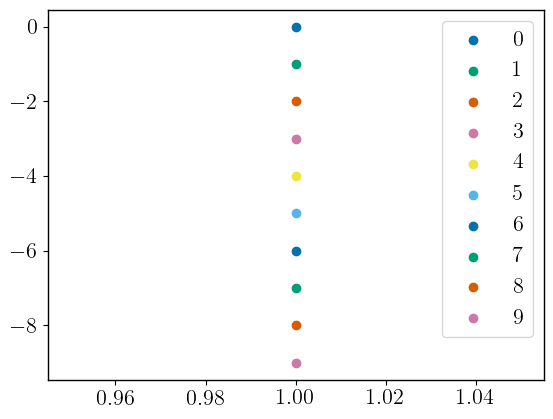

In [38]:
import matplotlib.pyplot as plt

# Set some matplotlib parameters to make it look very nice and LaTex like and professional and really good ready for publication

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 16
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams["text.usetex"] = True
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["axes.edgecolor"] = "black"

# Plot 10 random lines to test the colors
# Set also the colors to be visually pleasing and colorblind friendly
plt.style.use('seaborn-v0_8-colorblind')
plt.rcParams["image.cmap"] = "viridis"

for i in range(10):
    plt.scatter(1, -i, label=i)
plt.legend()
plt.show()

In [39]:
# Make a function to save the figures
# I want to save the figures in a folder called figures
# The prefix of the figure filename needs to be the same as the notebook filename
# The figures folder is located in PROJECT_DIR/notbooks/figures

# Path: Results.ipynb
import os
import matplotlib.pyplot as plt
import optosim
from optosim.settings import PROJECT_DIR

def save_figure(fig, filename, notebook_name=notebook_name):
    """Save a matplotlib figure in the figures folder of the project.
    The prefix of the figure filename needs to be the same as the notebook filename
    The figures folder is located in PROJECT_DIR/notbooks/figures

    Args:
        fig (matplotlib.figure.Figure): Matplotlib figure to save
        filename (str): Filename of the notebook
        prefix (str, optional): Prefix of the figure filename. Defaults to None.
        folder (str, optional): Folder to save the figure in. Defaults to "figures".
    """

    prefix = notebook_name.lower()

    folder = "figures"

    # Save one png and one pdf version of the figure
    fig.savefig(os.path.join(PROJECT_DIR, "notebook", folder, f"{prefix}-{filename}.png"), dpi=300, bbox_inches="tight")
    fig.savefig(os.path.join(PROJECT_DIR, "notebook", folder, f"{prefix}-{filename}.pdf"), dpi=300, bbox_inches="tight")

    print(f"Figure saved as {prefix}_{filename}")

### Read the simulation data

In [40]:
show_data(DATA_DIR)

Found 10 subdirectories
Subdirectories:
['mc0006', 'mc0007', 'mc0010', 'mc0011', 'mc0012', 'mc0020', 'test_mc0000', 'test_mc0001', 'test_mc0002', 'test_mc0003']
File /data/xenon/optosim/data/test_mc0003/test_mc0003.0000.hdf5 is currently open by another process. Skipping...


,subdir,detector,nevents,nphoton_per_event,scatter,experimental_scatter_model,radius
0,mc0006,XAMS,10000,"[1000, 25000]",NaN,NaN,3.2
1,mc0007,XENONnT,10000,"[1000, 25000]",NaN,NaN,65.0
2,mc0010,XAMS,10000,"[100, 100000]",True,True,3.2
3,mc0011,XAMS,10000,"[100, 100000]",True,False,3.2
4,mc0012,XAMS,10000,"[100, 100000]",False,NaN,3.2
5,mc0020,XAMS,10000,"[100, 100000]",True,True,3.2


In [41]:
run_id = 'mc0020'
nmax = 5_000

# read data
run_id_dir = os.path.join(DATA_DIR, run_id)
files = glob.glob(run_id_dir + '/*.hd*')

# Invert the order of the files
files = files[::-1]

print(f"Reading data from {run_id_dir}")
print(f"Found {len(files)} files")

for f in files:
    print(f)


Reading data from /data/xenon/optosim/data/mc0020
Found 80 files
/data/xenon/optosim/data/mc0020/mc0020.0092.hdf5
/data/xenon/optosim/data/mc0020/mc0020.0069.hdf5
/data/xenon/optosim/data/mc0020/mc0020.0023.hdf5
/data/xenon/optosim/data/mc0020/mc0020.0041.hdf5
/data/xenon/optosim/data/mc0020/mc0020.0061.hdf5
/data/xenon/optosim/data/mc0020/mc0020.0085.hdf5
/data/xenon/optosim/data/mc0020/mc0020.0062.hdf5
/data/xenon/optosim/data/mc0020/mc0020.0086.hdf5
/data/xenon/optosim/data/mc0020/mc0020.0024.hdf5
/data/xenon/optosim/data/mc0020/mc0020.0043.hdf5
/data/xenon/optosim/data/mc0020/mc0020.0063.hdf5
/data/xenon/optosim/data/mc0020/mc0020.0091.hdf5
/data/xenon/optosim/data/mc0020/mc0020.0078.hdf5
/data/xenon/optosim/data/mc0020/mc0020.0068.hdf5
/data/xenon/optosim/data/mc0020/mc0020.0048.hdf5
/data/xenon/optosim/data/mc0020/mc0020.0051.hdf5
/data/xenon/optosim/data/mc0020/mc0020.0095.hdf5
/data/xenon/optosim/data/mc0020/mc0020.0072.hdf5
/data/xenon/optosim/data/mc0020/mc0020.0039.hdf5
/dat

In [78]:
from optosim.simulation.event_reader import EventReader
e = EventReader(files[:5])

EventReader initialized with:
  number of files:  5
  number of events:  50000
  configuration:  {'detector': 'XAMS', 'nevents': 10000, 'nphoton_per_event': [100, 100000], 'energy_scale': 'linear', 'photon_zgen': 0.5, 'geometry': {'type': 'cylinder', 'radius': 3.2, 'ztop': 1.2, 'zliq': 0.0, 'zbot': -6.7, 'ptfe_zmin': -5.32, 'ptfe_zmax': -0.25}, 'npmt_xy': 2, 'pmt': {'type': 'square', 'size': 2.54, 'ndivs': 10}, 'scatter': True, 'experimental_scatter_model': True, 'data_type_version': 2.0}


In [79]:
e.data_dict.keys()

dict_keys(['fine_bot', 'fine_top', 'nphoton', 'number', 'pmt_bot', 'pmt_top', 'true_position'])

In [80]:

true_pos = e.data_dict['true_position']
fine_top = e.data_dict['fine_top']
top = e.data_dict['pmt_top']
n_true_photon = e.data_dict['nphoton']    

# transpose every element of top. So not top itself but every element of top
top = np.array([np.transpose(t) for t in top])
fine_top = np.array([np.transpose(t) for t in fine_top])



In [81]:
len(true_pos)

50000

In [82]:
# Apply a mask here

# number of photons in pmt_top is > 100
mask = n_true_photon >= 0

true_pos = true_pos[mask]
fine_top = fine_top[mask]
top = top[mask]
n_true_photon = n_true_photon[mask]



In [83]:
len(true_pos)

50000

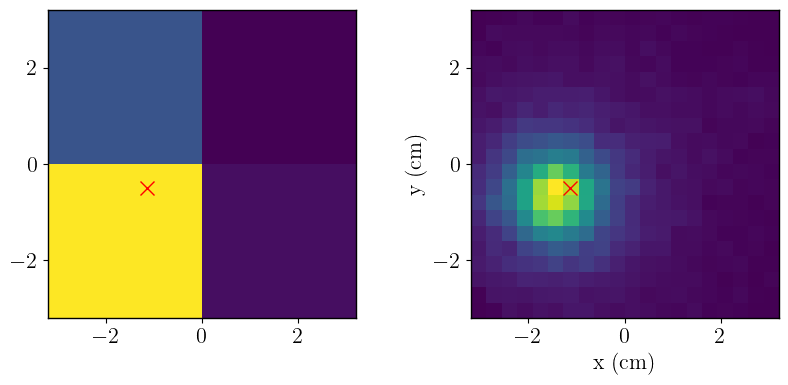

In [84]:
# check if data is ok
num = 1
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax = ax.ravel()
r = 3.2

ax[0].imshow(
    top[num], 
    interpolation="nearest", 
    origin="lower", 
    extent=[-r, r, -r, r]
)

ax[1].imshow(
    fine_top[num],
    interpolation="nearest",
    origin="lower",
    extent=[-r, r, -r, r],
)

for i in range(2):
    ax[i].plot(
        true_pos[num][0],
        true_pos[num][1],
        marker="x",
        markersize=10,
        color="red",
        label="true position",
    )

plt.xlabel("x (cm)")
plt.ylabel("y (cm)")
plt.show()

### Make test data

In [392]:
# create train and test sets
y = np.asarray(fine_top)
X = np.asarray(top)
pos = [pos[:2] for pos in true_pos] # depth is not used

X_train, y_train, pos_train, X_test, y_test, pos_test = create_datasets(X, y, pos, train_fraction=0)

In [393]:
len(X_train), len(X_test)

(0, 50000)

In [394]:
# Weighted average estimator

wa_pred = weighted_average_estimator(X_test, r=3.2)
wa_mse = mse(pos_test, wa_pred)
wa_r2 = r_squared(pos_test, wa_pred)

### Get the models

In [395]:
# Utils

# Let's make a function to read the models from the pickle files
def read_model(model_name):

    print(f"Reading model {model_name}")
    model_file = os.path.join(MODEL_DIR, run_id, model_name)
    with open(model_file, 'rb') as f:
        model = pickle.load(f)

    return model

# Define a function to get the number of pmts from a filename like model_2x2_mc0006.pkl
def get_pmts_from_filename(filename):
    return int(filename.split("_")[1].split('x')[0])

# Define a function to get the run id from a filename like model_2x2_mc0006.pkl
def get_filename_from_pmts(pmts_per_dim, run_id):
    return f"model_{pmts_per_dim}x{pmts_per_dim}_{run_id}.pkl"


In [396]:


# Define list of models to read
read_all_models = True

if read_all_models:
    # Let's read all the files, nicely sorted, 
    # only the filename without the path,
    # Sort in a way that 2 comes before 10
    models_to_read = [os.path.basename(x) for x in glob.glob(os.path.join(MODEL_DIR, run_id, f"*{run_id}*.pkl"))]
    models_to_read = sorted(models_to_read, key=lambda x: int(get_pmts_from_filename(x)))
else: 
    # Read only these files
    pmts_per_dim_to_load = [2,3,4,5,6,7,8,9,10,11,12]
    models_to_read = [get_filename_from_pmts(pmts_per_dim, run_id) for pmts_per_dim in pmts_per_dim_to_load]


# Let's read all the files
models = {}
for model_name in models_to_read:
    models[model_name] = read_model(model_name)

# Let's make a function to predict the position of the events


Reading model model_2x2_mc0010.pkl
Reading model model_3x3_mc0010.pkl
Reading model model_4x4_mc0010.pkl
Reading model model_5x5_mc0010.pkl
Reading model model_6x6_mc0010.pkl
Reading model model_7x7_mc0010.pkl
Reading model model_8x8_mc0010.pkl
Reading model model_9x9_mc0010.pkl
Reading model model_10x10_mc0010.pkl
Reading model model_11x11_mc0010.pkl
Reading model model_12x12_mc0010.pkl
Reading model model_13x13_mc0010.pkl
Reading model model_14x14_mc0010.pkl
Reading model model_15x15_mc0010.pkl
Reading model model_16x16_mc0010.pkl
Reading model model_17x17_mc0010.pkl
Reading model model_18x18_mc0010.pkl
Reading model model_19x19_mc0010.pkl
Reading model model_20x20_mc0010.pkl


In [397]:
# Make a result dictionary with the results for each model

results = {}

for model_name, model in models.items():
    print(f"Predicting with model {model_name}")

    _pmts = get_pmts_from_filename(model_name)
    res = model.evaluate(X_test[mask], pos_test[mask])

    results[model_name] = {}
    results[model_name]['PMTs'] = _pmts
    results[model_name]['pred'] = res['pred']
    results[model_name]['pred_heatmap'] = res['pred_heatmap']
    results[model_name]['MSE'] = res['MSE']
    results[model_name]['R^2'] = res['R^2']


Predicting with model model_2x2_mc0010.pkl
Predicting with model model_3x3_mc0010.pkl
Predicting with model model_4x4_mc0010.pkl
Predicting with model model_5x5_mc0010.pkl
Predicting with model model_6x6_mc0010.pkl
Predicting with model model_7x7_mc0010.pkl
Predicting with model model_8x8_mc0010.pkl
Predicting with model model_9x9_mc0010.pkl
Predicting with model model_10x10_mc0010.pkl
Predicting with model model_11x11_mc0010.pkl
Predicting with model model_12x12_mc0010.pkl
Predicting with model model_13x13_mc0010.pkl
Predicting with model model_14x14_mc0010.pkl
Predicting with model model_15x15_mc0010.pkl
Predicting with model model_16x16_mc0010.pkl
Predicting with model model_17x17_mc0010.pkl
Predicting with model model_18x18_mc0010.pkl
Predicting with model model_19x19_mc0010.pkl
Predicting with model model_20x20_mc0010.pkl


## Let's make nice plots

- 2d histogram of true x - x vs true y - y :: resolution of best model\\
- 1d histogram of true r - r :: resolution of best model\\
- comparison of resolutions (MSE/R2) for different models\\
- error correlation with position\\

We decide that the best model is 5x5

In [398]:
radius = 3.2

model: model_2x2_mc0010.pkl           --PMTS: 2 -- RSE: 0.1882 -- R^2: 0.9268
model: model_3x3_mc0010.pkl           --PMTS: 3 -- RSE: 0.2682 -- R^2: 0.8957
model: model_4x4_mc0010.pkl           --PMTS: 4 -- RSE: 0.4708 -- R^2: 0.8169
model: model_5x5_mc0010.pkl           --PMTS: 5 -- RSE: 0.9717 -- R^2: 0.6221
model: model_6x6_mc0010.pkl           --PMTS: 6 -- RSE: 0.4968 -- R^2: 0.8068
model: model_7x7_mc0010.pkl           --PMTS: 7 -- RSE: 0.5680 -- R^2: 0.7791
model: model_8x8_mc0010.pkl           --PMTS: 8 -- RSE: 0.6393 -- R^2: 0.7514
model: model_9x9_mc0010.pkl           --PMTS: 9 -- RSE: 0.4260 -- R^2: 0.8343
model: model_10x10_mc0010.pkl         --PMTS: 10 -- RSE: 0.9856 -- R^2: 0.6167
model: model_11x11_mc0010.pkl         --PMTS: 11 -- RSE: 0.5294 -- R^2: 0.7941
model: model_12x12_mc0010.pkl         --PMTS: 12 -- RSE: 0.4483 -- R^2: 0.8256
model: model_13x13_mc0010.pkl         --PMTS: 13 -- RSE: 0.5546 -- R^2: 0.7843
model: model_14x14_mc0010.pkl         --PMTS: 14 -- RSE: 0.4

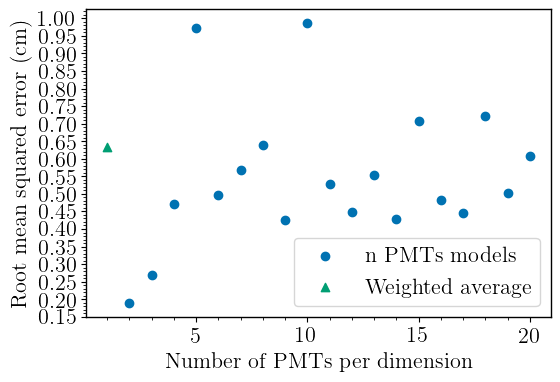

In [399]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_mse_scatter(results, wa_mse, figsize=(6, 4)):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Get the first color of the color cycle from the style
    color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]

    for i, model_name in enumerate(results.keys()):
        res = results[model_name]
        print(f"model: {model_name:<30} --PMTS: {res['PMTs']} -- RSE: {res['MSE']:.4f} -- R^2: {res['R^2']:.4f}")
        if i == 0:
            ax.scatter(res['PMTs'], res['MSE'], label='n PMTs models', color=color)
        else:
            ax.scatter(res['PMTs'], res['MSE'], c=color)

    color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
    ax.scatter(1, wa_mse, marker='^', color=color, label="Weighted average")

    ax.set_ylabel("Root mean squared error (cm)")
    ax.set_xlabel("Number of PMTs per dimension")
    ax.set_axisbelow(True)
    yaxis = ax.yaxis
    yaxis.set_major_formatter(ticker.ScalarFormatter())
    yaxis.set_major_locator(ticker.MultipleLocator(0.05))
    yaxis.set_minor_locator(ticker.MultipleLocator(0.01))
    xaxis = ax.xaxis
    xaxis.set_major_locator(ticker.MultipleLocator(5))
    xaxis.set_minor_locator(ticker.MultipleLocator(1))
    xaxis.set_major_formatter(ticker.ScalarFormatter())
    plt.legend()

# Usage
plot_mse_scatter(results, wa_mse)


In [400]:
stupid_model_name = f'model_2x2_{run_id}.pkl'
stupid_model = models[stupid_model_name]

model_name = f'model_5x5_{run_id}.pkl'
model = models[model_name]

finest_model_name = f'model_20x20_{run_id}.pkl'
finest_model = models[finest_model_name]

In [401]:
pred_pos = results[model_name]['pred']
stupid_pred_pos = results[stupid_model_name]['pred']
finest_pred_pos = results[finest_model_name]['pred']

_pmts = results[model_name]['PMTs']
_stupid_pmts = results[stupid_model_name]['PMTs']
_finest_pmts = results[finest_model_name]['PMTs']


In [402]:
# Get the radius of the events
r = np.linalg.norm(pos_test, axis=1)

r_pred = np.linalg.norm(pred_pos, axis=1)
stupid_r_pred = np.linalg.norm(stupid_pred_pos, axis=1)
finest_model_r_pred = np.linalg.norm(finest_pred_pos, axis=1)


# Get the delta r
dr = r_pred - r
stupid_dr = stupid_r_pred - r
finest_dr = finest_model_r_pred - r
wa_dr = np.linalg.norm(wa_pred - pos_test, axis=1)

# Get the distance between the predicted and true positions
dist = np.linalg.norm(pred_pos - pos_test, axis=1)
stupid_model_dist = np.linalg.norm(stupid_pred_pos - pos_test, axis=1)
wa_dist = np.linalg.norm(wa_pred - pos_test, axis=1)
finest_model_dist = np.linalg.norm(finest_pred_pos - pos_test, axis=1)



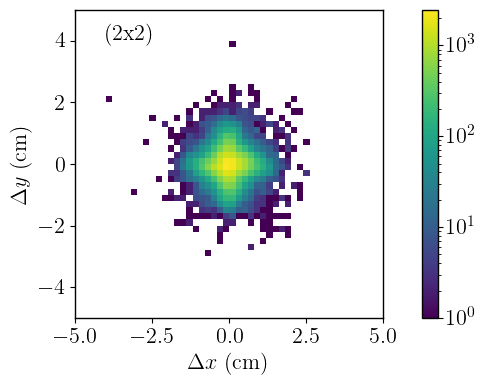

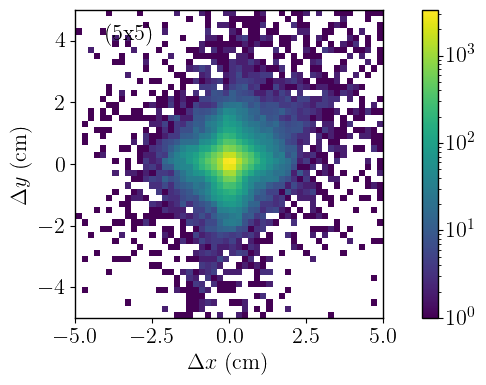

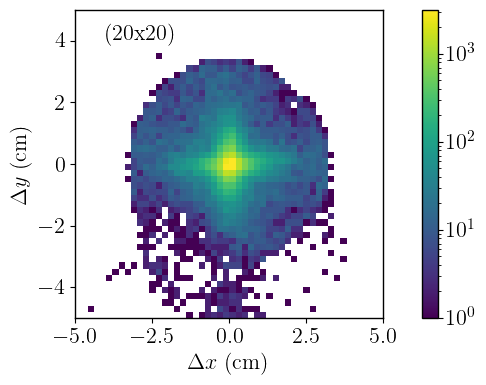

In [403]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def plot_2d_histogram(true_pos, predicted_pos, model_name, model_details, bins=50, range=((-5,5),(-5,5))):
    """
    Plot a 2D histogram for the deviation in x and y positions.

    Parameters:
    - true_pos: True positions.
    - predicted_pos: Predicted positions from the model.
    - model_name: Name of the model.
    - model_details: Additional details about the model (e.g., number of PMTs).
    - bins: Number of bins for the histogram.
    - range: Range for the histogram.
    """
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))

    plt.hist2d(
        predicted_pos[:,0] - true_pos[:,0],
        predicted_pos[:,1] - true_pos[:,1],
        bins=bins,
        norm=LogNorm(),
        range=range
    )

    plt.xlabel("$\Delta x$ (cm)")
    plt.ylabel("$\Delta y$ (cm)")
    plt.colorbar()
    ax.set_aspect(1)
    plt.text(range[0][0] + 0.1*(range[0][1]-range[0][0]), range[1][1] - 0.1*(range[1][1]-range[1][0]), f"({model_details})", fontsize=16)

    plt.show()

# Usage
for model in [stupid_model_name, model_name, finest_model_name]:
    plot_2d_histogram(pos_test, results[model]['pred'], model, f"{results[model]['PMTs']}x{results[model]['PMTs']}")


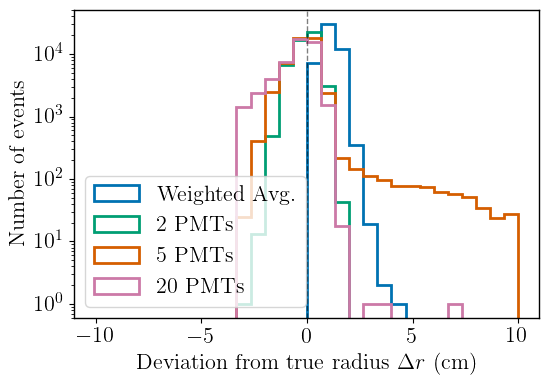

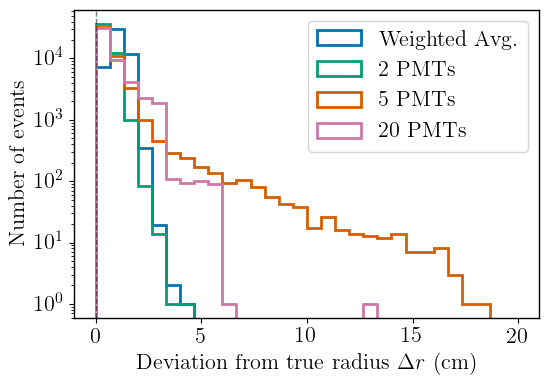

In [404]:
import matplotlib.pyplot as plt

def plot_histogram(data_list, labels, xlabel, ylabel, range=None, n_bins=30, log_scale=False, save_path=None):
    """
    Plot histograms for a list of data.

    Parameters:
    - data_list: List of data arrays to plot.
    - labels: Labels for each data array.
    - xlabel: Label for the x-axis.
    - ylabel: Label for the y-axis.
    - range: Range for the histogram.
    - n_bins: Number of bins.
    - log_scale: Whether to use a logarithmic scale on the y-axis.
    - save_path: Path to save the figure (optional).
    """
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))

    for data, label in zip(data_list, labels):
        plt.hist(
            data,
            bins=n_bins,
            range=range,
            label=label,
            histtype="step",
            linewidth=2,
        )

    plt.axvline(0, color="black", linestyle="--", linewidth=1, alpha=0.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()

    if log_scale:
        plt.yscale('log')

    if save_path:
        plt.savefig(save_path)

    plt.show()

# Usage
values = [wa_dr, stupid_dr, dr, finest_dr]
labels = ["Weighted Avg.", f"{_stupid_pmts} PMTs", f"{_pmts} PMTs", f"{_finest_pmts} PMTs"]
plot_histogram(values, labels, "Deviation from true radius $\Delta r$ (cm)", "Number of events", range=(-10,10), log_scale=True, save_path=f"dr_per_model_{run_id}.png")


values = [wa_dist, stupid_model_dist, dist, finest_model_dist]
labels = ["Weighted Avg.", f"{_stupid_pmts} PMTs", f"{_pmts} PMTs", f"{_finest_pmts} PMTs"]
plot_histogram(values, labels, "Deviation from true radius $\Delta r$ (cm)", "Number of events", range=(0,20), log_scale=True, save_path=f"dr_per_model_{run_id}.png")


In [405]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def compute_statistics(X, true_data, predicted_data_list, bins, statistic_func):
    """
    Compute statistics for a given property.
    
    Parameters:
    - true_data: The true values of the property.
    - predicted_data_list: A list of predicted values from different models.
    - bins: Binning for the x-axis data.
    - statistic_func: Function to compute the desired property (e.g., dr, xy_dist).
    
    Returns:
    - binned_statistic_list: A list of binned statistics for each model.
    """
    binned_statistic_list = []
    
    for predicted_data in predicted_data_list:
        diff = statistic_func(true_data, predicted_data)
        mean, _, _ = stats.binned_statistic(X, diff, statistic='mean', bins=bins)
        std, _, _ = stats.binned_statistic(X, diff, statistic='std', bins=bins)
        binned_statistic_list.append((mean, std))
        
    return binned_statistic_list

def plot_statistics(x_data, bins, binned_statistic_list, labels):
    """
    Plot the computed statistics.
    
    Parameters:
    - x_data: Data for the x-axis.
    - bins: Binning for the x-axis data.
    - binned_statistic_list: Output from compute_statistics.
    - labels: Labels for each model.
    """
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    
    for (mean, std), label in zip(binned_statistic_list, labels):
        plt.plot(bins[:-1], mean, label=label, linewidth=2)
        plt.fill_between(bins[:-1], mean - std, mean + std, alpha=0.2)
    
    plt.legend()

# Define your statistic functions
def func_dr(true_pos, pred_pos):
    _r = np.linalg.norm(true_pos, axis=1)
    _pred_r = np.linalg.norm(pred_pos, axis=1)
    result = _pred_r - _r
    return result

def func_xy_dist(true_pos, pred_pos):
    return np.linalg.norm(pred_pos - true_pos, axis=1)



Text(0, 0.5, 'Average $\\Delta$XY (cm)')

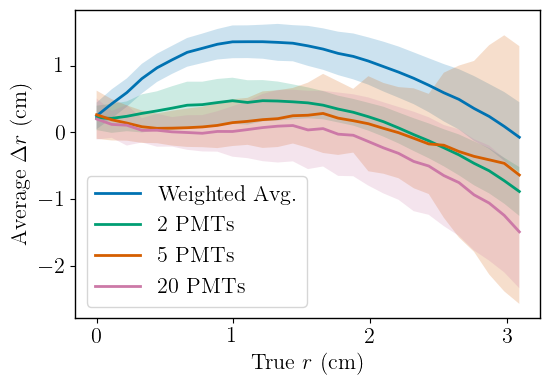

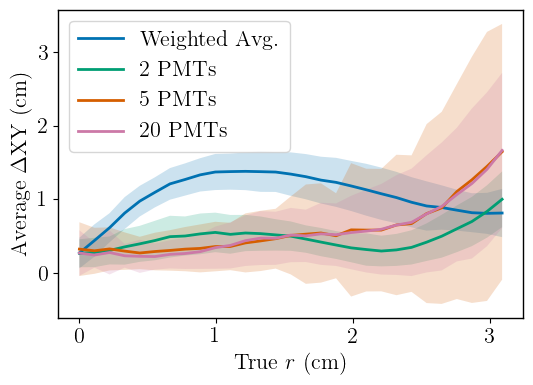

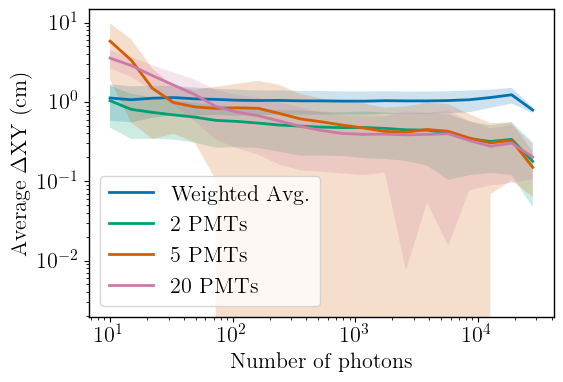

In [406]:

labels = ["Weighted Avg.", f"{_stupid_pmts} PMTs", f"{_pmts} PMTs", f"{_finest_pmts} PMTs"]


bins = np.linspace(0, 3.2, 30)
r = np.linalg.norm(pos_test, axis=1)

statistics = compute_statistics(r, pos_test, [wa_pred, stupid_pred_pos, pred_pos, finest_pred_pos], bins, func_dr)
plot_statistics(r, bins, statistics, labels)
plt.xlabel("True $r$ (cm)")
plt.ylabel("Average $\Delta r$ (cm)")

statistics = compute_statistics(r, pos_test, [wa_pred, stupid_pred_pos, pred_pos, finest_pred_pos], bins, func_xy_dist)
plot_statistics(r, bins, statistics, labels)
plt.xlabel("True $r$ (cm)")
plt.ylabel("Average $\Delta$XY (cm)")

bins = np.logspace(1, 6, 30)
n_photons = np.sum(X_test, axis=(1, 2))
statistics = compute_statistics(n_photons, pos_test, [wa_pred, stupid_pred_pos, pred_pos, finest_pred_pos], bins, func_xy_dist)
plot_statistics(n_photons, bins, statistics, labels)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of photons")
plt.ylabel("Average $\Delta$XY (cm)")

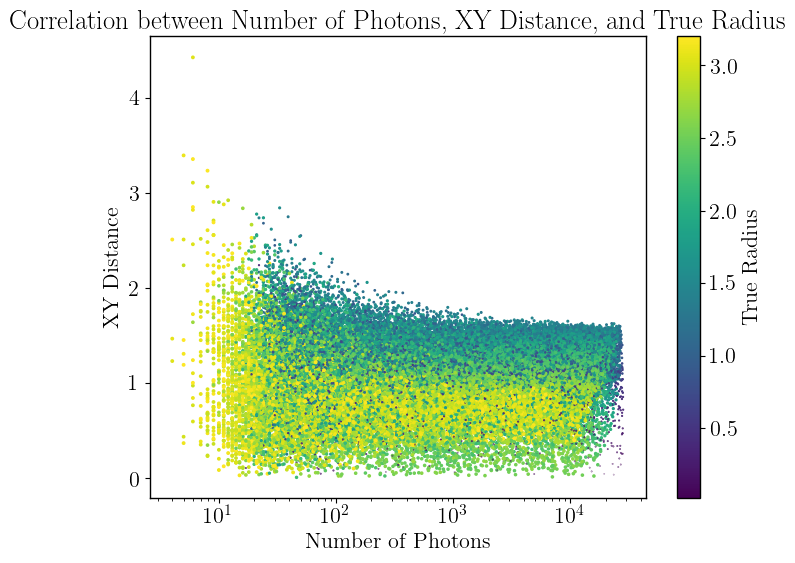

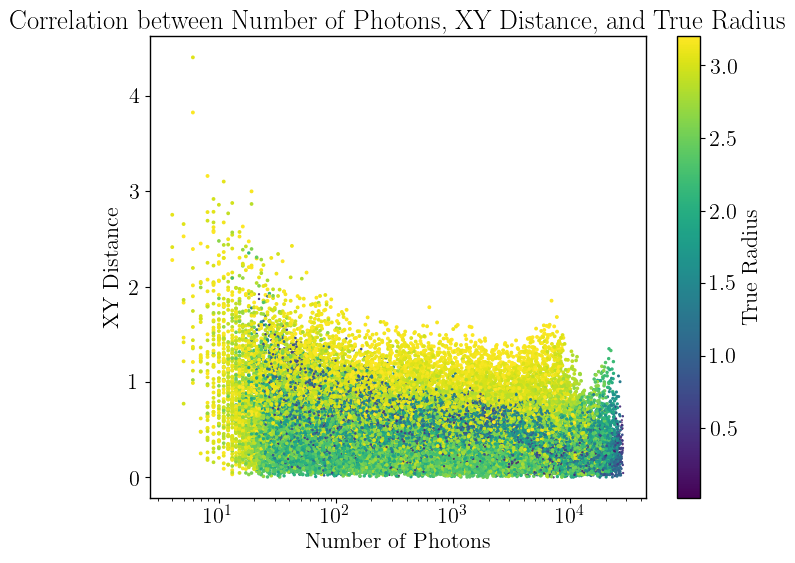

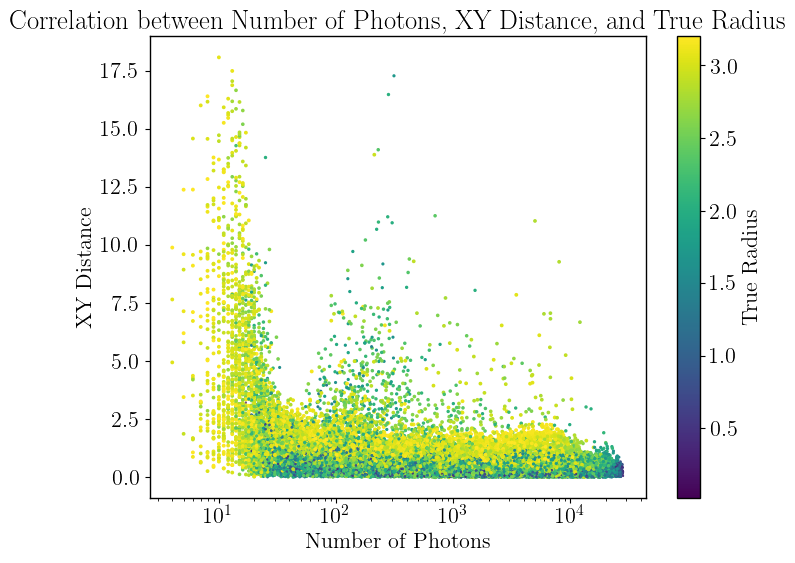

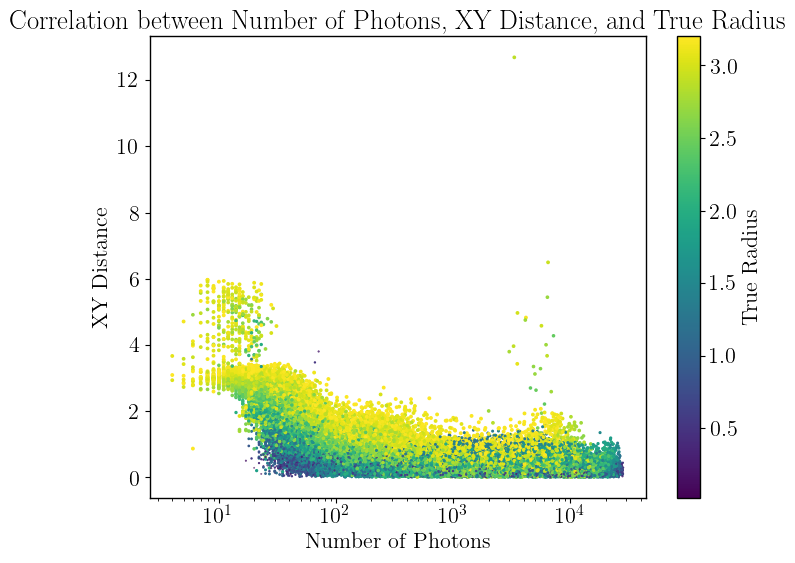

In [407]:
import matplotlib.pyplot as plt
import numpy as np

def plot_3d_correlation(n_photons, xydist, true_radius):
    """
    Plot a 3D scatter plot to visualize the correlation between number of photons, xydist, and true radius.

    Parameters:
    - n_photons: Array of number of photons.
    - xydist: Array of xy distances.
    - true_radius: Array of true radii.
    """
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)

    scatter = ax.scatter(n_photons, xydist, true_radius, c=true_radius, cmap='viridis')
    ax.set_xlabel('Number of Photons')
    ax.set_ylabel('XY Distance')
    ax.set_title('Correlation between Number of Photons, XY Distance, and True Radius')
    
    # Add a colorbar to represent the true radius values
    cbar = fig.colorbar(scatter, ax=ax, label='True Radius')

    ax.set_xscale('log')
    

# Usage

n_photons = np.sum(X_test, axis=(1, 2))
r = np.linalg.norm(pos_test, axis=1)

for predicted_position in [wa_pred, stupid_pred_pos, pred_pos, finest_pred_pos]:
    xydist = np.linalg.norm(predicted_position - pos_test, axis=1)
    plot_3d_correlation(n_photons, xydist, r)





Plotting loss curve for model model_2x2_mc0010.pkl


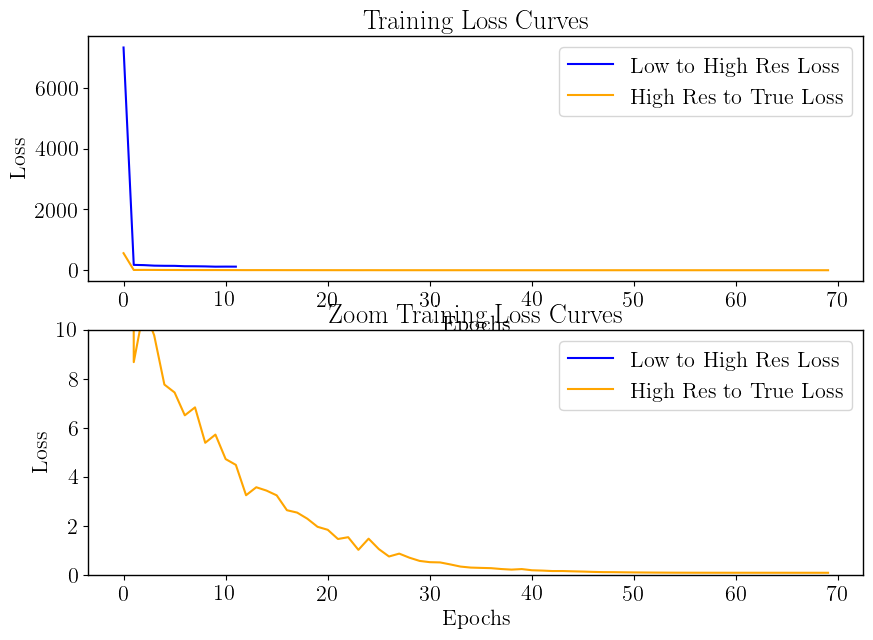

Plotting loss curve for model model_3x3_mc0010.pkl


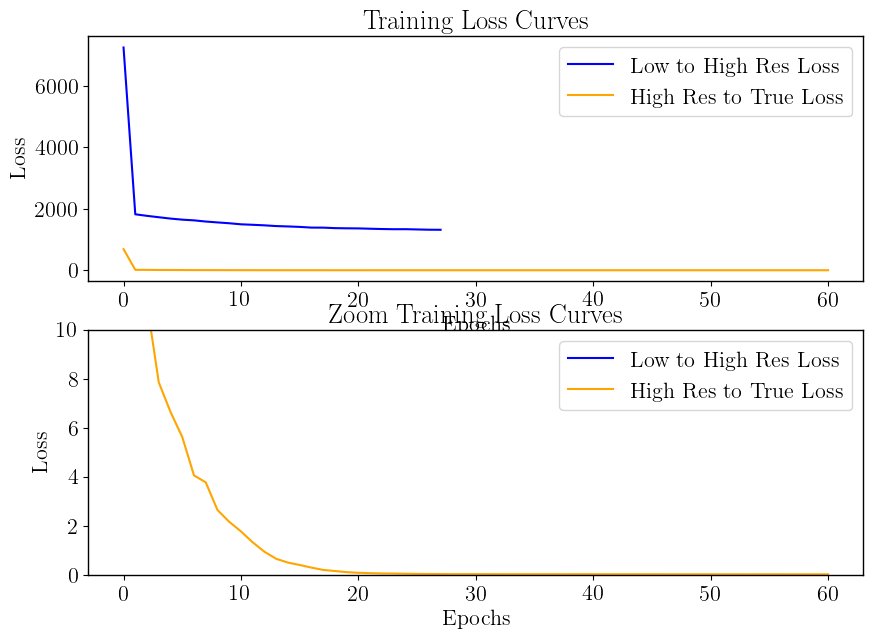

Plotting loss curve for model model_4x4_mc0010.pkl


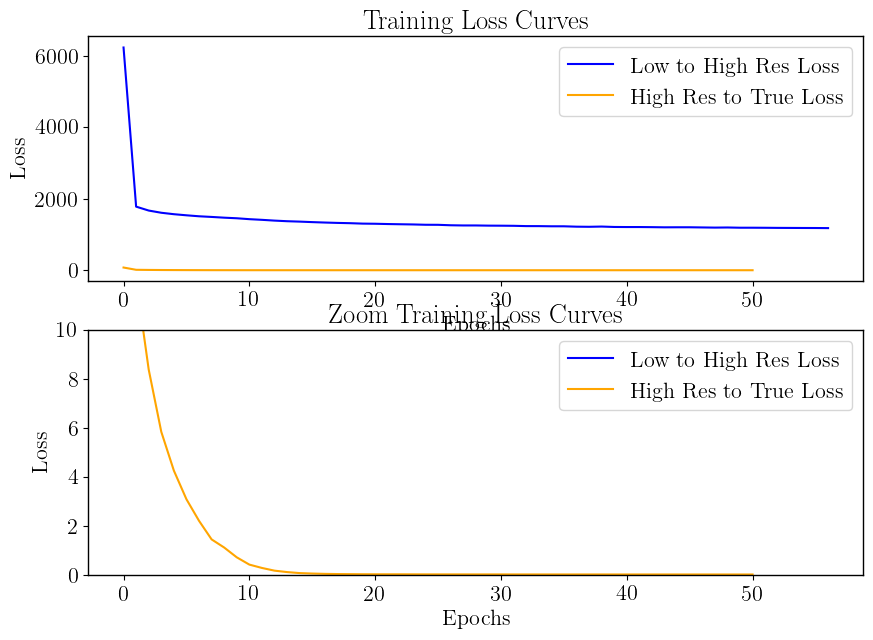

Plotting loss curve for model model_5x5_mc0010.pkl


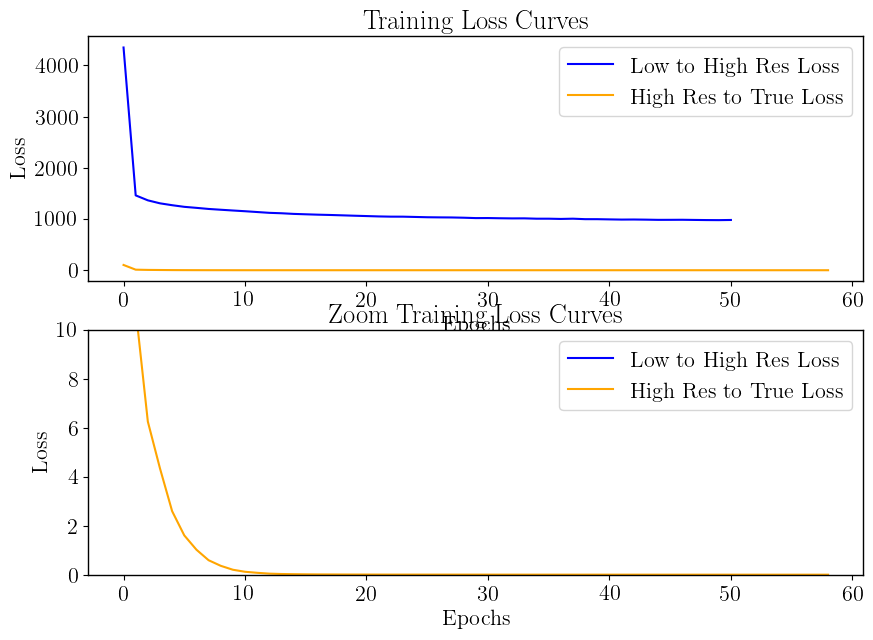

Plotting loss curve for model model_6x6_mc0010.pkl


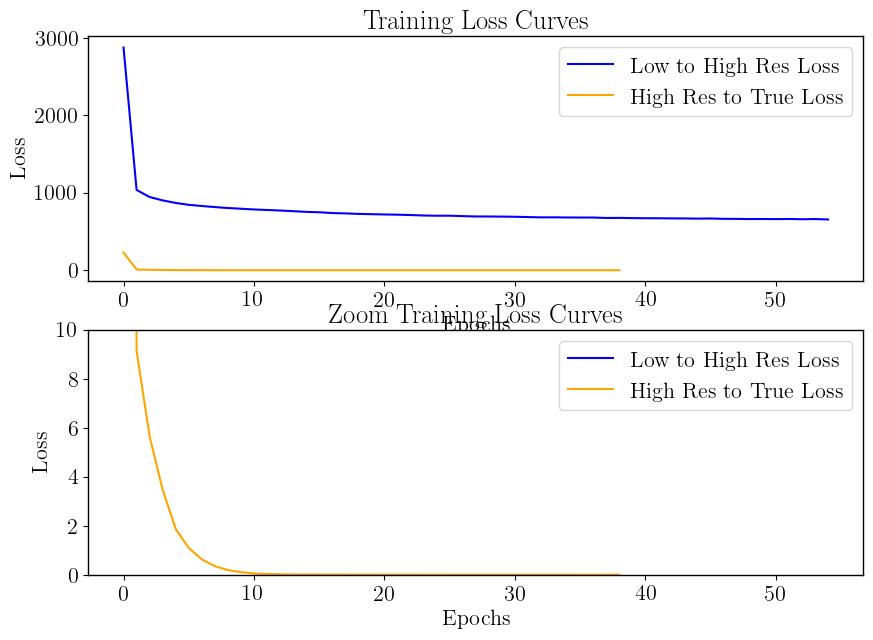

Plotting loss curve for model model_7x7_mc0010.pkl


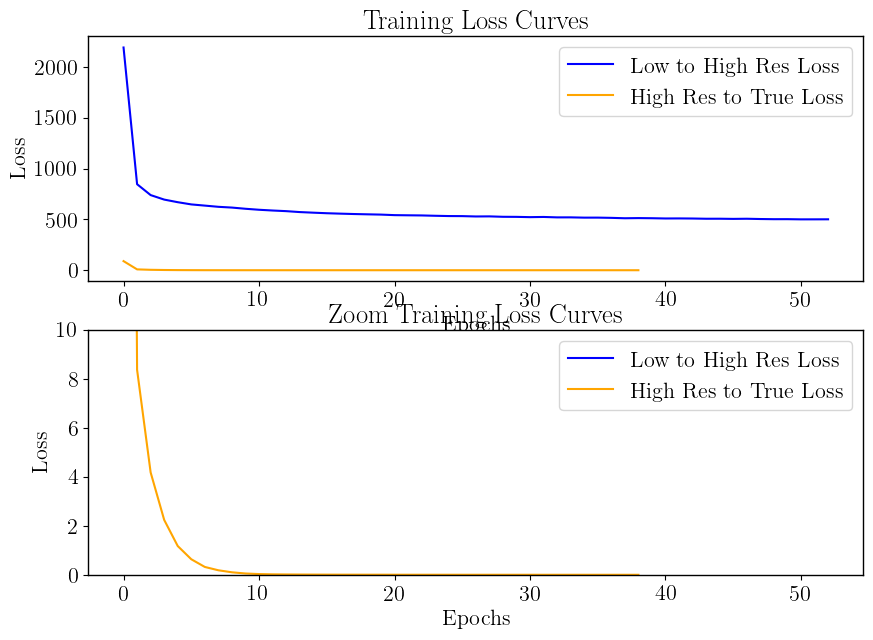

Plotting loss curve for model model_8x8_mc0010.pkl


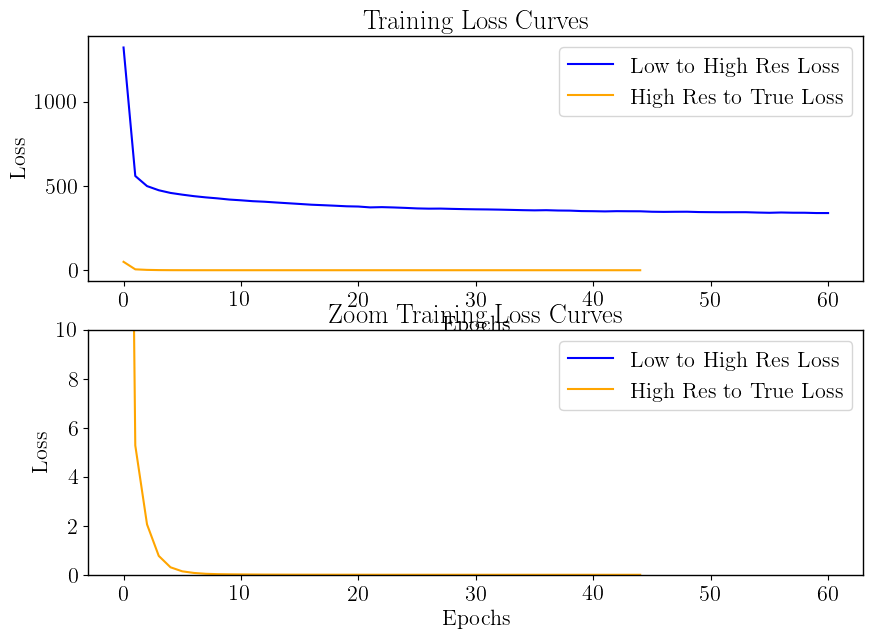

Plotting loss curve for model model_9x9_mc0010.pkl


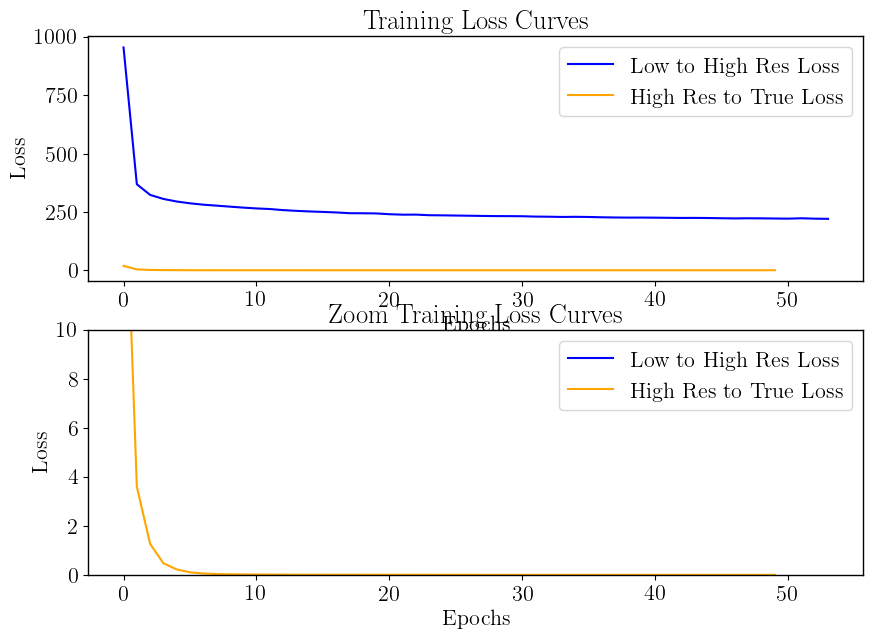

Plotting loss curve for model model_10x10_mc0010.pkl


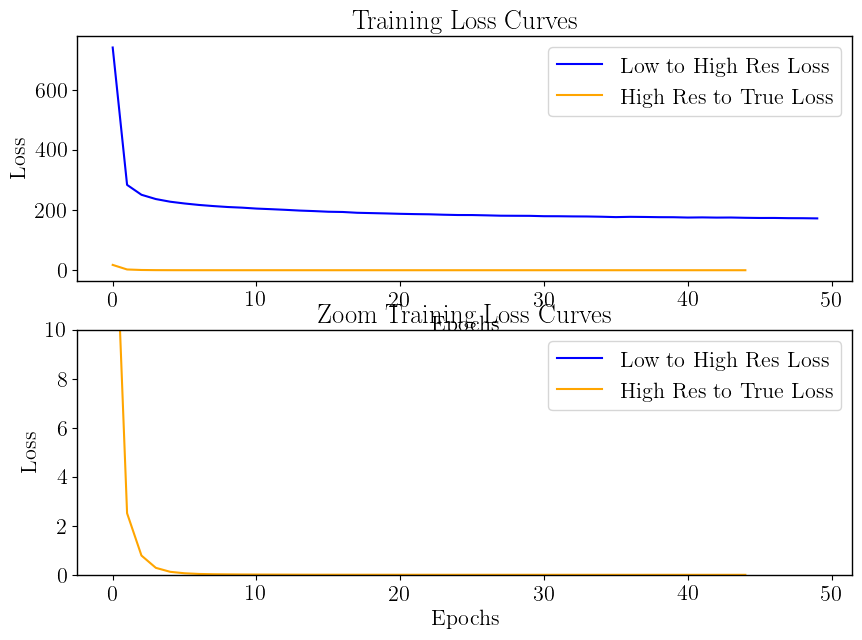

Plotting loss curve for model model_11x11_mc0010.pkl


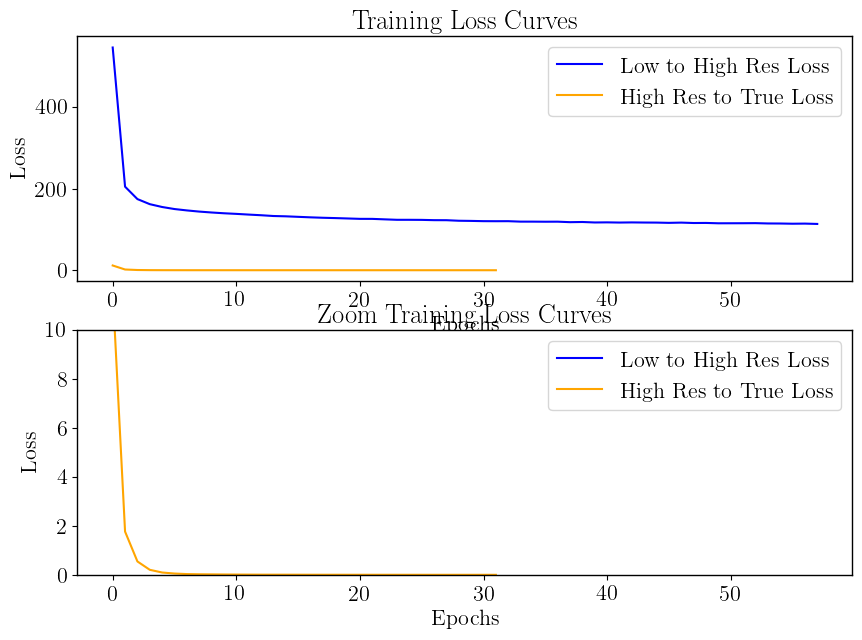

Plotting loss curve for model model_12x12_mc0010.pkl


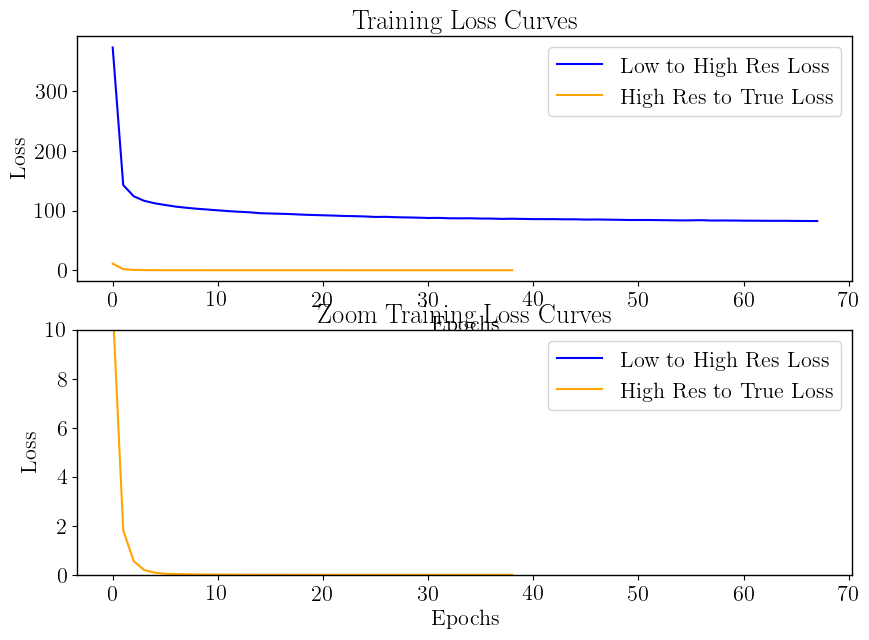

Plotting loss curve for model model_13x13_mc0010.pkl


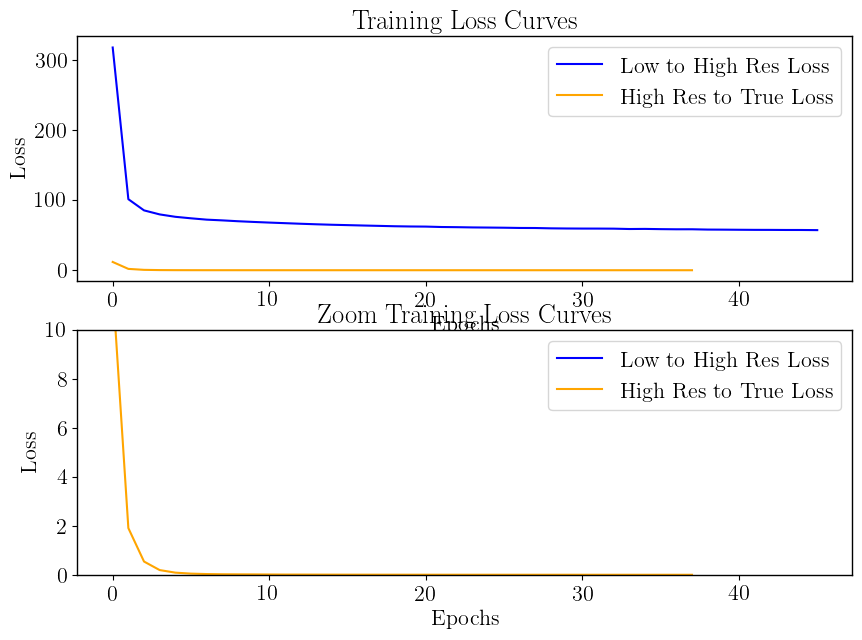

Plotting loss curve for model model_14x14_mc0010.pkl


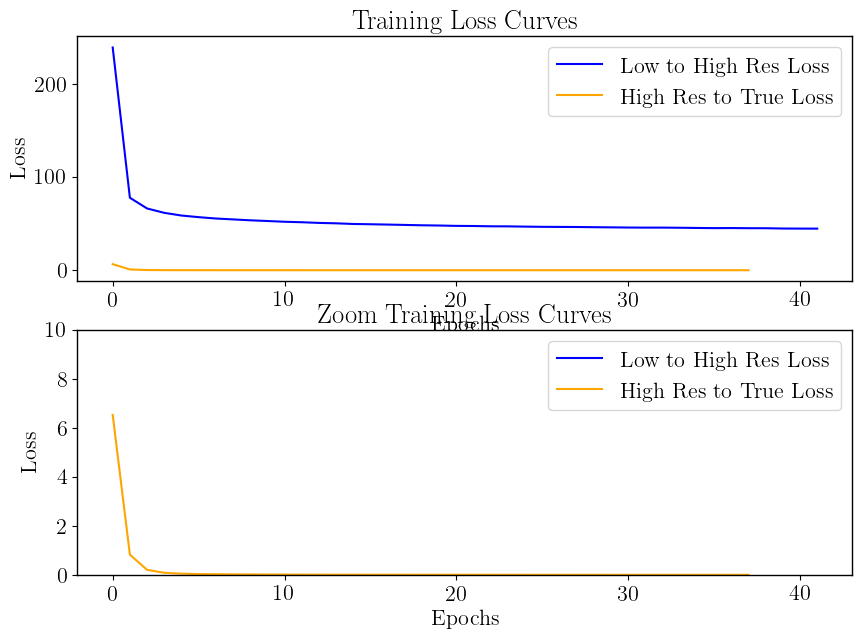

Plotting loss curve for model model_15x15_mc0010.pkl


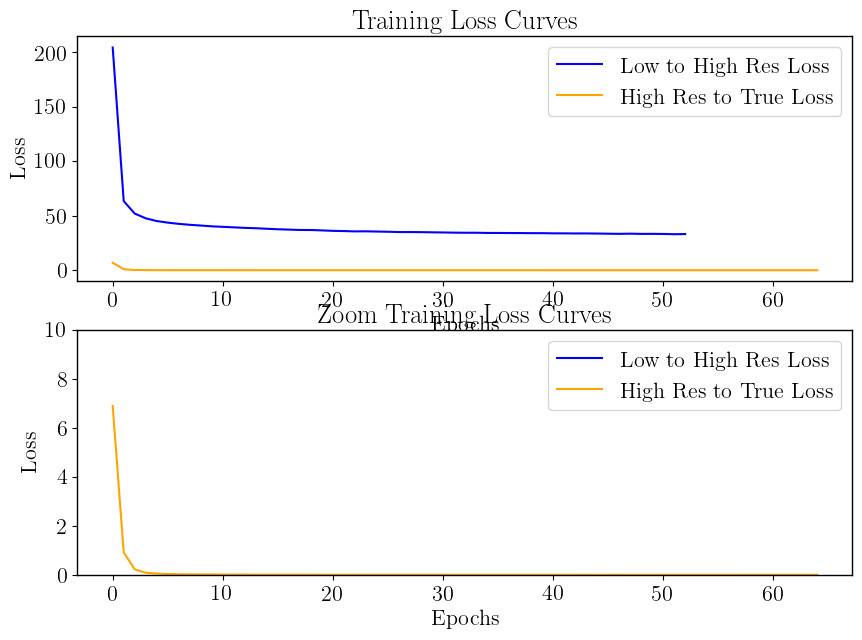

Plotting loss curve for model model_16x16_mc0010.pkl


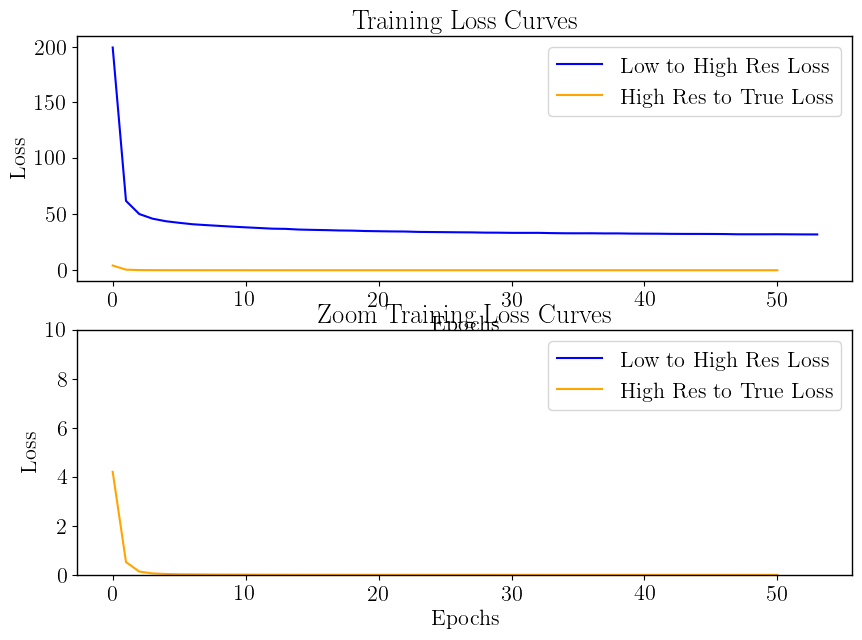

Plotting loss curve for model model_17x17_mc0010.pkl


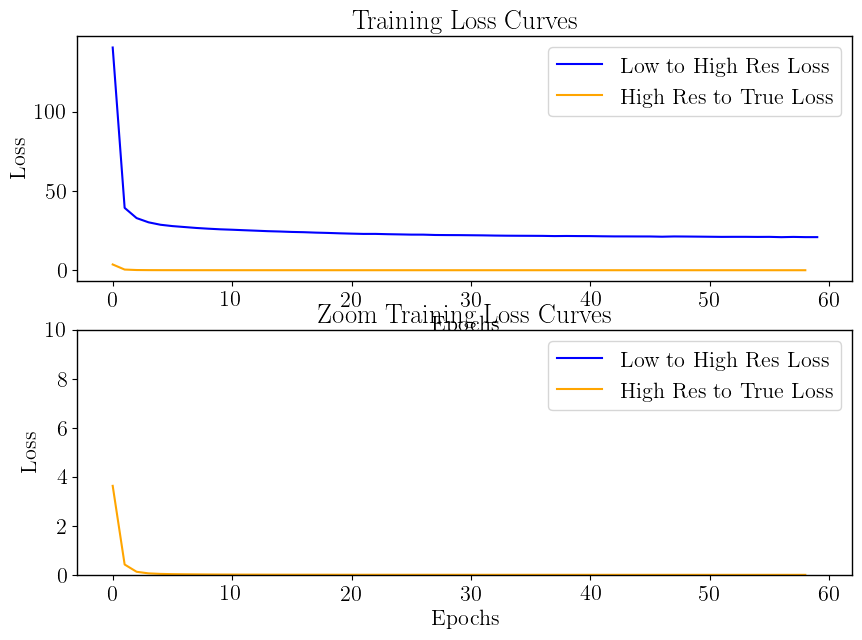

Plotting loss curve for model model_18x18_mc0010.pkl


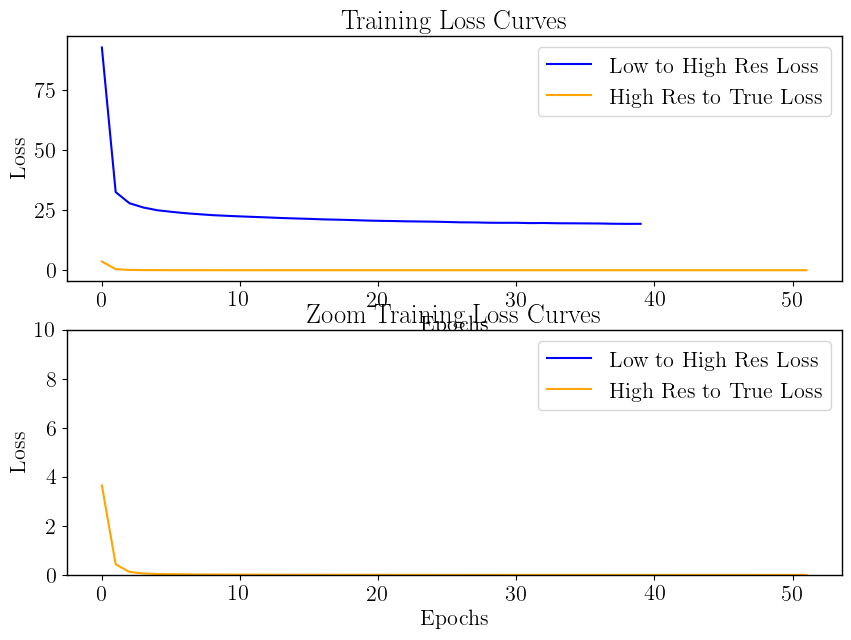

Plotting loss curve for model model_19x19_mc0010.pkl


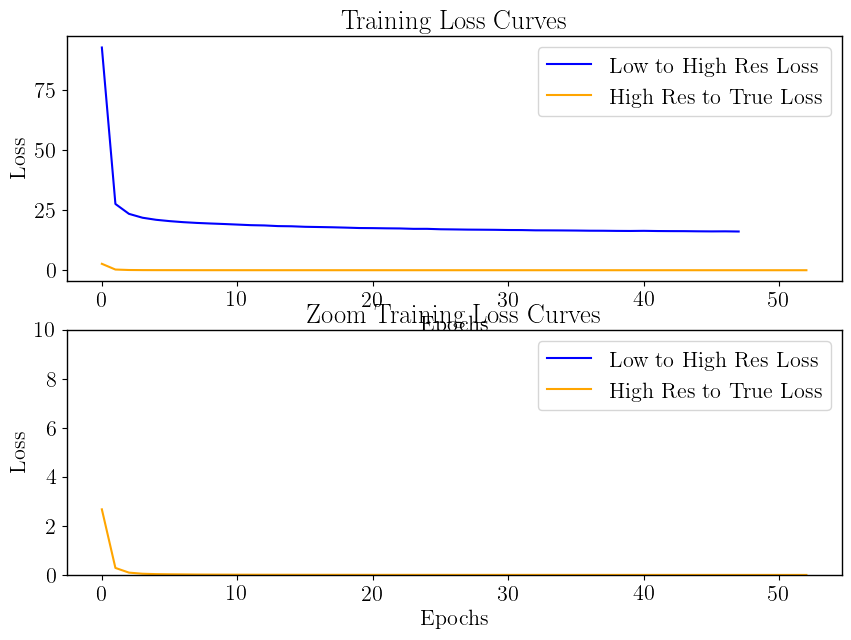

Plotting loss curve for model model_20x20_mc0010.pkl


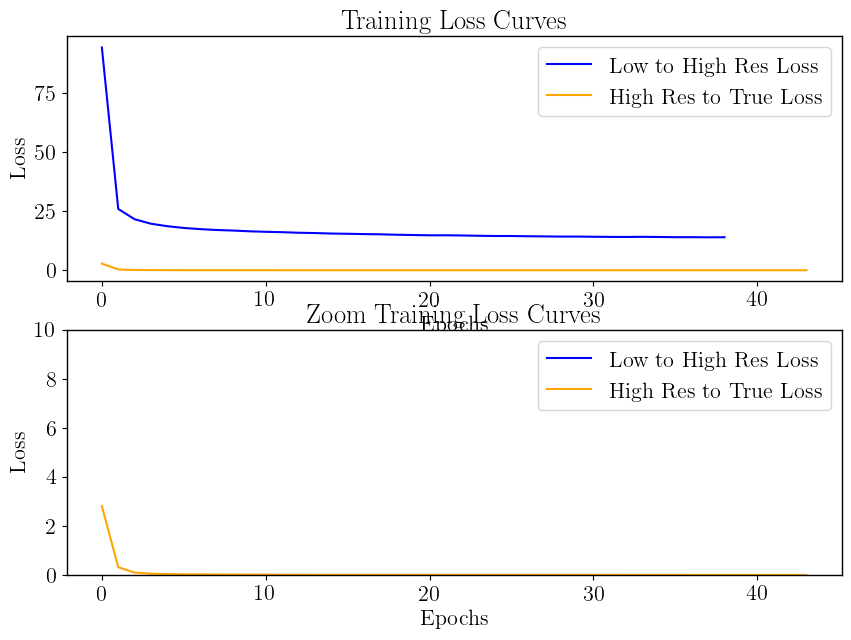

In [408]:
for model_name, model in models.items():
    print(f"Plotting loss curve for model {model_name}")
    loss = model.plot_loss_curve()

## Check one by one

In [409]:
# check if data is ok

from matplotlib.colors import LogNorm

# import make_axes_locatable
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_one_event(test_heat, predicted_heat, true_heat, true_downsampled_heat, predicted_pos, true_pos, wa_pos):


    # have the y shared between the plots
    fig, ax = plt.subplots(1, 4, figsize=(18, 4), sharey=True)

    ax = ax.ravel()

    values = [
        test_heat,
        predicted_heat,
        true_downsampled_heat,
        true_heat,
    ]

    titles = [
        "Test event",
        "Predicted event",
        "True downsampled",
        "True event",
    ]

    # find min and max of all the values[i]
    vmin = np.min([np.min(v) for v in values])
    vmax = np.max([np.max(v) for v in values])

    for i in range(len(values)):

        im = ax[i].imshow(
            values[i],
            interpolation="nearest",
            origin="lower",
            extent=[-r, r, -r, r],
            # set the same vmax and vmin for all the plots
            # vmin=vmin,
            # vmax=vmax,
        )

        ax[i].set_title(titles[i])

        markersize = 15

        ax[i].plot(
            true_pos[0],
            true_pos[1],
            marker="X",
            markersize=markersize,
            color="red",
            label="true position",
        )

        ax[i].plot(
            predicted_pos[0],
            predicted_pos[1],
            marker="^",
            markersize=markersize,
            color="cyan",
            label="predicted position",
        )

        ax[i].plot(
            wa_pos[0],
            wa_pos[1],
            marker="d",
            markersize=markersize,
            color="m",
            label="Weighted average",
        )

        ax[i].set_xlabel("x (cm)")

        # Add a small text with the total amount of hits
        # so sum all the values in the multi-dimensional array
        ax[i].text(
            -1.5,
            4.2,
            f"Total hits: {np.sum(values[i]):.1f}",
            fontsize=12,
            color="k",
        )

        # add a colorbar right next to the plot without space in between
        divider = make_axes_locatable(ax[i])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

    ax[0].set_ylabel("y (cm)")

    # put the legend above the subplots 
    # centralised with respect to the figure
    ax[-1].legend(
        bbox_to_anchor=(-1.5, 1.5), 
        loc='upper center', 
        ncol=3, 
        fontsize=16
    )

    plt.show()


In [410]:
# Get the number of hits for each event
n_hits = np.sum(X_test, axis=(1, 2))
n_hits[:10]

array([  82, 2231, 4336,  673,  175,   57, 8763,  388,   86,   39])

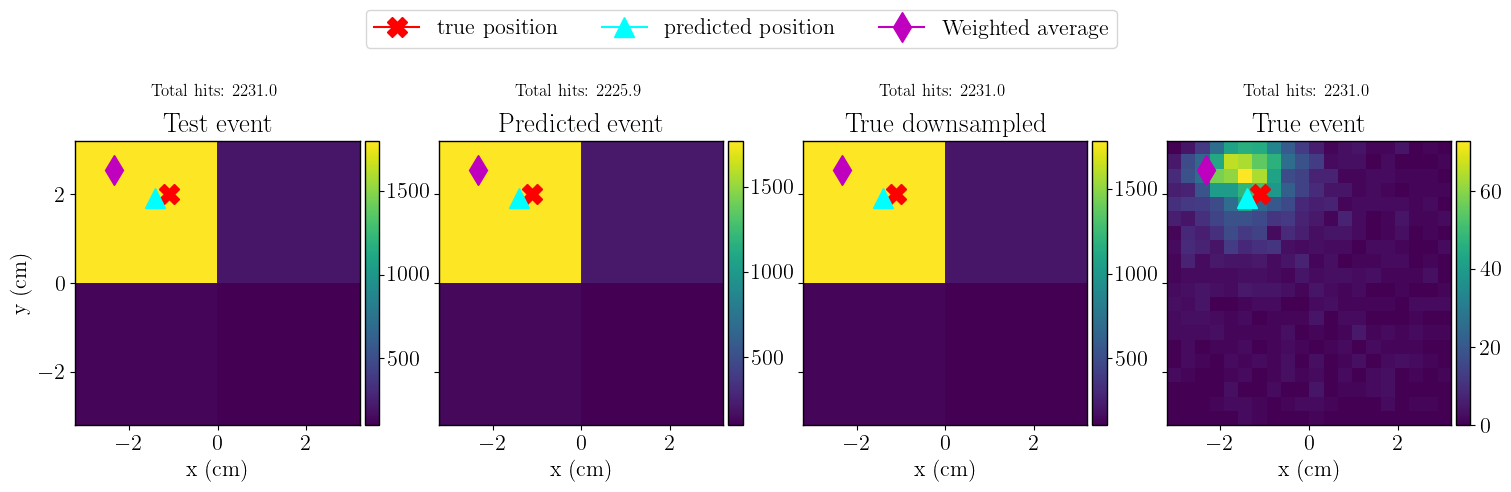

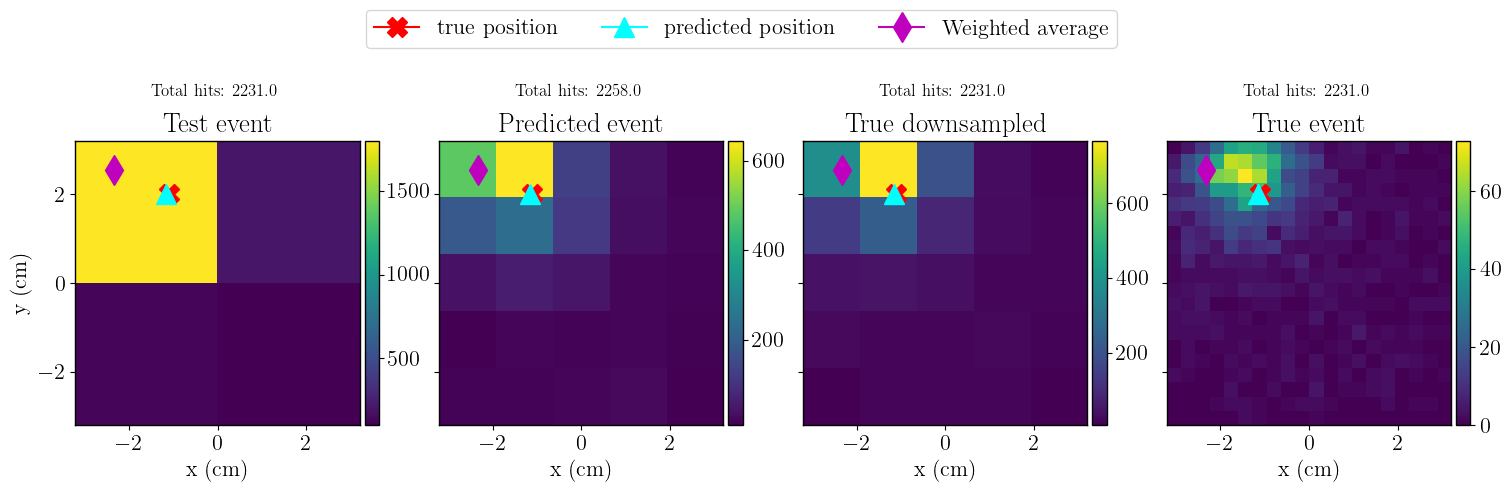

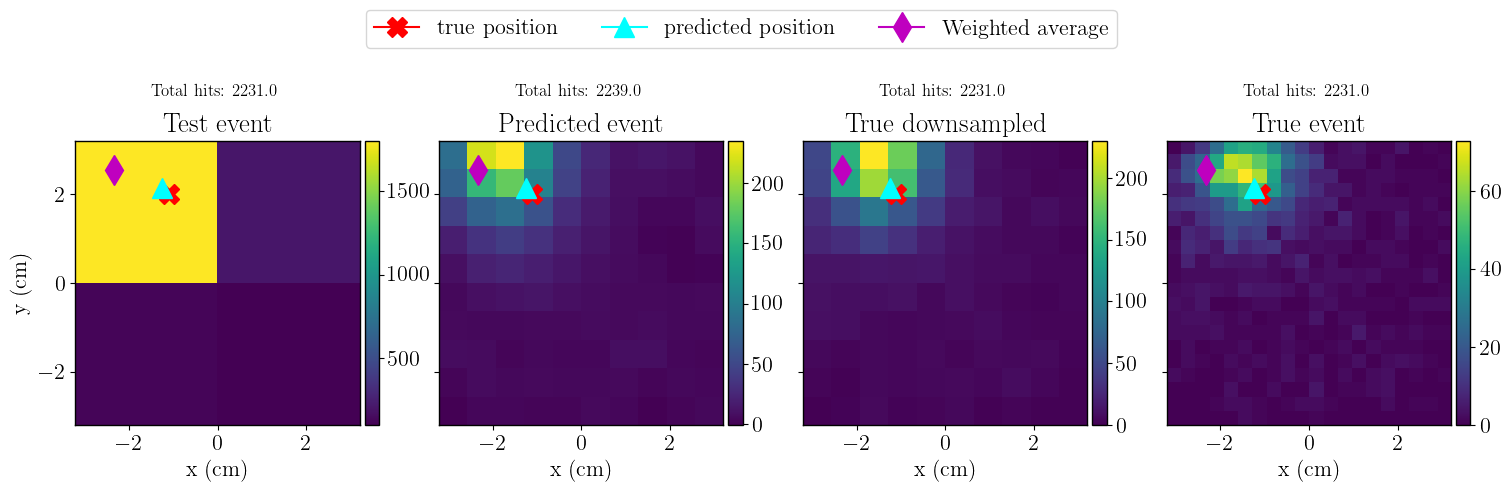

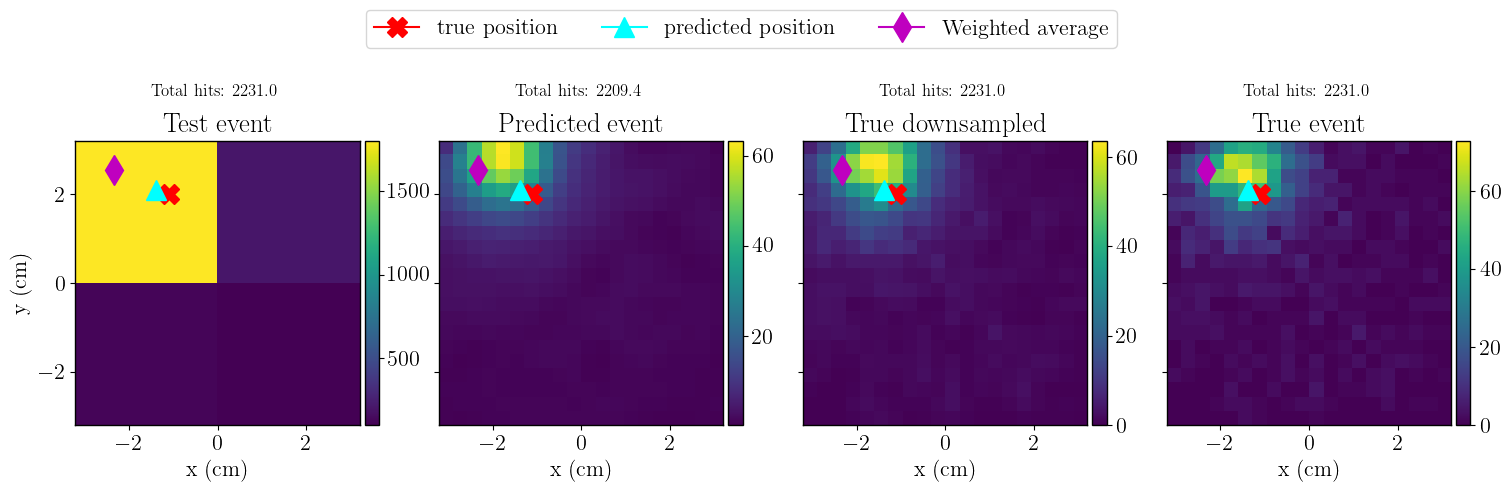

In [411]:
n_pmts = 10
i = 1
r = 3.2

# for n_pmts in range(2,20) one every 3

for n_pmts in [2, 5, 10, 20]:

    model = models[f'model_{n_pmts}x{n_pmts}_{run_id}.pkl']

    one_test_heat = X_test[i]

    one_true_pos = pos_test[i]
    one_true_heat = y_test[i]
    one_true_downsampled_heat = downsample_heatmaps_to_dimensions(np.array([one_true_heat, ]), n_pmts, n_pmts)[0]

    one_pred_heat, one_pred_pos = model.predict(np.array([X_test[i], ]))
    one_pred_heat = one_pred_heat[0]
    one_pred_heat = one_pred_heat.reshape(n_pmts,n_pmts)
    one_pred_pos = one_pred_pos[0]

    one_wa_pos = weighted_average_estimator(np.array([one_test_heat, ]), r=r)[0]

    plot_one_event(
        one_test_heat, 
        one_pred_heat, 
        one_true_heat, 
        one_true_downsampled_heat, 
        one_pred_pos, 
        one_true_pos, 
        one_wa_pos
    )

In [412]:
# Now i would like to make a figure in which i do the plot_one_event but for 5 different models. So basically every model a row, and in each row 4 columns, one for each plot_one_event


event_i = 5

def plot_one_event_together(event_i, r=3.2):
    
    n_pmts_list = [2, 5, 10, 20]

    fig, ax = plt.subplots(len(n_pmts_list), 4, figsize=(18, 20), sharey=True)

    for j, n_pmts in enumerate(n_pmts_list):

        model = models[f'model_{n_pmts}x{n_pmts}_{run_id}.pkl']

        one_test_heat = X_test[event_i]
        one_true_pos = pos_test[event_i]
        one_true_heat = y_test[event_i]

        one_true_downsampled_heat = downsample_heatmaps_to_dimensions(np.array([one_true_heat, ]), n_pmts, n_pmts)[0]

        one_pred_heat, one_pred_pos = model.predict(np.array([one_test_heat, ]))
        one_pred_heat = one_pred_heat[0]
        one_pred_pos = one_pred_pos[0]

        one_pred_heat = one_pred_heat.reshape(n_pmts,n_pmts)

        one_wa_pos = weighted_average_estimator(np.array([one_test_heat, ]), r=r)[0]

        values = [
            one_test_heat,
            one_pred_heat,
            one_true_downsampled_heat,
            one_true_heat,
        ]

        titles = [
            f"Test event (2x2)",
            f"Predicted event ({n_pmts}x{n_pmts})",
            f"True downsampled ({n_pmts}x{n_pmts})",
            f"True event (20x20)",
        ]

        # find min and max of all the values[i]
        vmin = np.min([np.min(v) for v in values])
        vmax = np.max([np.max(v) for v in values])

        for i in range(len(values)):

            im = ax[j, i].imshow(
                values[i],
                interpolation="nearest",
                origin="lower",
                extent=[-r, r, -r, r],
                # set the same vmax and vmin for all the plots
                # vmin=vmin,
                # vmax=vmax,
            )

            ax[j, i].set_title(titles[i])

            markersize = 15

            ax[j, i].plot(
                one_true_pos[0],
                one_true_pos[1],
                marker="X",
                markersize=markersize,
                color="red",
                label="true position",
            )

            ax[j, i].plot(
                one_pred_pos[0],
                one_pred_pos[1],
                marker="^",
                markersize=markersize,
                color="cyan",
                label="predicted position",
            )

            ax[j, i].plot(
                one_wa_pos[0],
                one_wa_pos[1],
                marker="d",
                markersize=markersize,
                color="m",
                label="Weighted average",
            )

            ax[j, i].set_xlabel("x (cm)")

            # Add a small text with the total amount of hits
            # so sum all the values in the multi-dimensional array
            # let's move this text in a small frame in the bottom right of the plot

            ax[j,i].text(
                1.1,
                -4.4,
                f"Tot. hits: {np.sum(values[i]):.1f}",
                fontsize=14,
                color="k",
                bbox=dict(
                    facecolor='white',
                    edgecolor='black',
                    boxstyle='round'
                )
            )

            # add a colorbar right next to the plot without space in between
            divider = make_axes_locatable(ax[j,i])
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(im, cax=cax)

            # ax[j,i].set_xlim(-r,r)
            # ax[j,i].set_ylim(-r,r)

        ax[j, 0].set_ylabel("y (cm)")

    # put the legend above the subplots 
    # centralised with respect to the figure
    ax[0, 3].legend(
        bbox_to_anchor=(-1.5, 1.35), 
        loc='upper center', 
        ncol=3, 
        fontsize=16
    )

    
    plt.show()

        

In [413]:
np.where(dist>10)

(array([   32,   184,   487,   770,   889,  1118,  1369,  1617,  1694,
         2014,  2614,  2961,  3153,  3469,  3827,  4184,  4254,  4338,
         4457,  4470,  4548,  5156,  5907,  6057,  6317,  6366,  6955,
         7524,  7637,  7808,  7853,  7924,  8170,  8474,  8797,  8898,
         9189, 10434, 10958, 11475, 12137, 12340, 12794, 12807, 13470,
        13496, 14326, 14691, 16824, 16960, 16985, 17020, 17086, 17196,
        17200, 17329, 17901, 18254, 18438, 19312, 19417, 19775, 19787,
        19860, 20162, 20262, 20620, 21473, 21573, 21671, 21917, 22952,
        24038, 24985, 25003, 25016, 27312, 27975, 28143, 28472, 29458,
        29585, 30005, 30264, 30683, 31165, 31208, 31287, 31626, 31664,
        31778, 31930, 31988, 32037, 32280, 32631, 33885, 34399, 34448,
        34460, 34689, 34926, 35224, 35441, 36154, 36267, 37392, 38009,
        39249, 39748, 40097, 40634, 40763, 40902, 41545, 42104, 43208,
        44061, 44837, 45121, 45307, 45475, 45665, 46167, 46197, 46257,
      

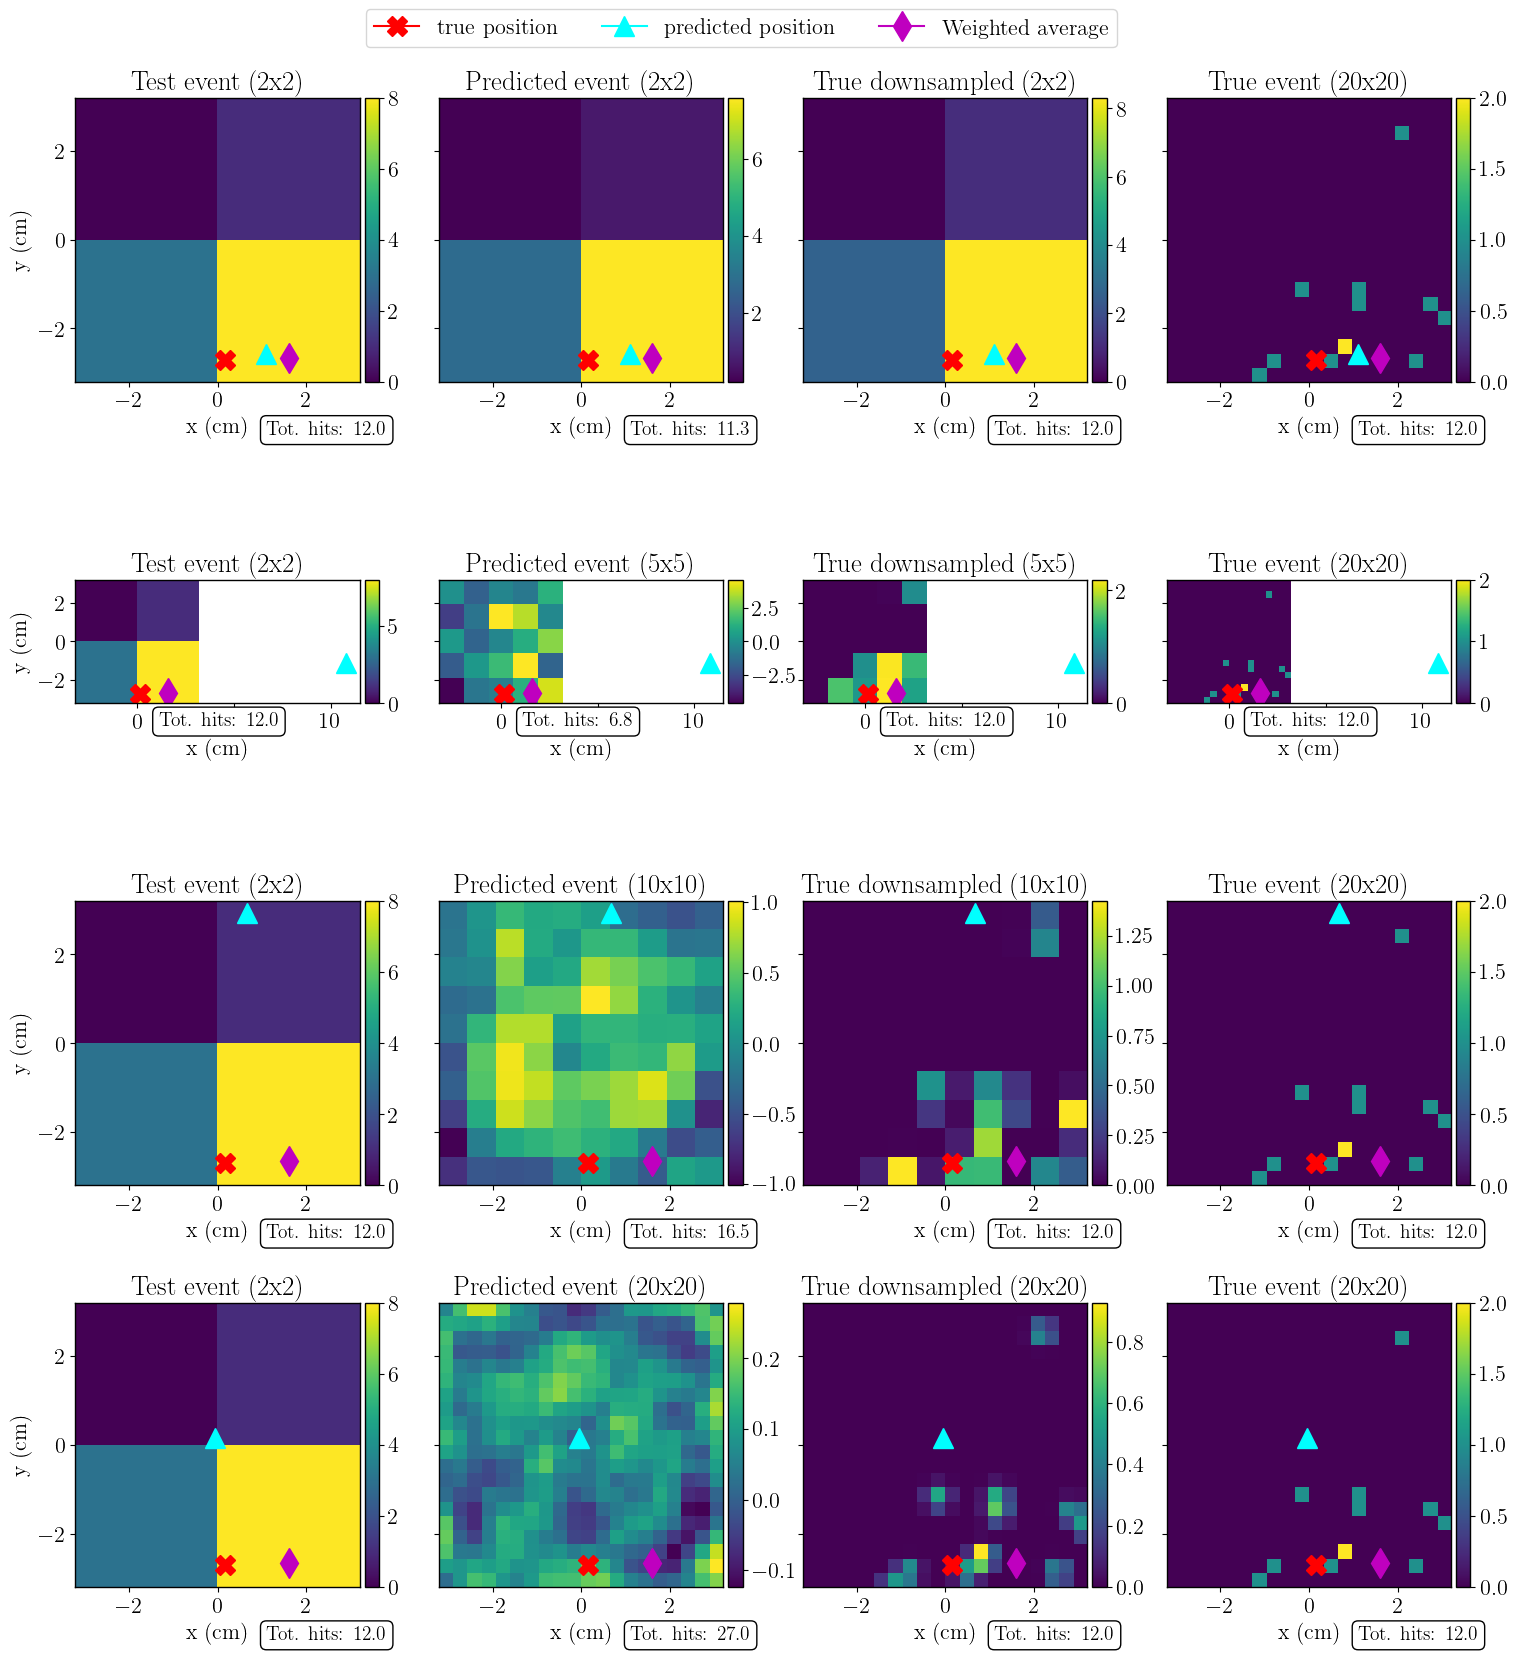

In [414]:
plot_one_event_together(487)